# Get Itemid List

This script is used for collecting all itemids in the database. Itemids are ids of features.

In this task we only collect itemids from the following tables:
- inputevents
- outputevents
- chartevents
- labevents
- microbiologyevents
- prescriptions

In [1]:
from __future__ import print_function

import psycopg2
import datetime
import sys
from operator import itemgetter, attrgetter, methodcaller
import numpy as np
import itertools
import os.path
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool, Process, Lock
from multiprocessing.sharedctypes import Value, Array
from ctypes import Structure, c_double, c_int

from utils import getConnection

%matplotlib inline

In [2]:
try:
    conn = getConnection()
    print('Connected to Postgre Database!')
except:
    print('Fail to connect!')

Connected to Postgre Database!


In [3]:
# load admission_ids
_adm = np.load('res/admission_ids.npy').tolist()
admission_ids = _adm['admission_ids']
admission_ids_txt = _adm['admission_ids_txt']

## Itemids from inputevents

Data from Carevue and Metavision is separately stored in TABLE INPUTEVENTS_CV and TABLE INPUTEVENTS_MV. Inputevents from Metavision have itemids >= 200000, and those from Carevue have itemids in [30000, 49999].

In [4]:
# itemid from inputevents
# sql = 'select distinct itemid from mimiciii.inputevents_cv where itemid >= 30000 and itemid <= 49999'
sql = '''
with inputitemids as (
        select distinct itemid from mimiciii.inputevents_mv where itemid >= 200000
        union
        select distinct itemid from mimiciii.inputevents_cv where itemid >= 30000 and itemid <= 49999
    )
select distinct itemid from inputitemids
'''
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
input_itemid = [r[0] for r in res]
input_itemid_txt = ','.join(map(str, input_itemid))

print("len(input_itemid) = ", len(input_itemid))

len(input_itemid) =  3216


## Itemids from outputevents

We only need to collect all distinct itemids in TABLE OUTPUTEVENTS.

In [5]:
# itemid from outputevents
# sql = 'select distinct itemid from mimiciii.outputevents where itemid >= 30000 and itemid <= 49999'
sql = 'select distinct itemid from mimiciii.outputevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
output_itemid = [r[0] for r in res]
output_itemid_txt = ','.join(map(str, output_itemid))

print("len(output_itemid) = ", len(output_itemid))

len(output_itemid) =  1155


## Itemids from chartevents

We only need to collect all distinct itemids in TABLE CHARTEVENTS.

In [6]:
# itemid from chartevents, should collect all ids <= 49999
# sql = 'select distinct itemid from mimiciii.chartevents where itemid <= 49999'
sql = 'select distinct itemid from mimiciii.chartevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
chart_itemid = [r[0] for r in res]
chart_itemid_txt = ','.join(map(str, chart_itemid))

print("len(chart_itemid) = ", len(chart_itemid))

len(chart_itemid) =  6463


## Itemids from labevents

We only need to collect all distinct itemids in TABLE LABEVENTS.

In [7]:
# itemid from labevenets
sql = 'select distinct itemid from mimiciii.labevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
lab_itemid = [r[0] for r in res]
lab_itemid_txt = ','.join(map(str, lab_itemid))

print("len(lab_itemid) = ", len(lab_itemid))

len(lab_itemid) =  726


## Itemids from microbiologyevents

We need to collect 4 kinds of itemids:
- spec_itemid
- org_itemid
- ab_itemid
- tuple of all above

In [8]:
# itemid from microbiologyevents
sql = 'select distinct (spec_itemid,org_itemid,ab_itemid),spec_itemid,org_itemid,ab_itemid from mimiciii.microbiologyevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
microbio_itemid = []
for r in res:
    ele = r[0][1:-1].split(',')
    for t in range(len(ele)):
        try:
            ele[t] = int(ele[t])
        except:
            ele[t] = None
    microbio_itemid.append(tuple(ele))

print("len(microbio_itemid) = ", len(microbio_itemid))

len(microbio_itemid) =  9154


## Itemids from prescriptions

We only need to collect all distinct itemids in TABLE PRESCRIPTIONS.

In [9]:
# itemid from prescriptions
sql = 'select distinct formulary_drug_cd from mimiciii.prescriptions'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
prescript_itemid = [r[0] for r in res]

print("len(prescript_itemid) = ", len(prescript_itemid))

len(prescript_itemid) =  3268


In [10]:
database = {'input':input_itemid,
            'output':output_itemid,
            'chart':chart_itemid,
            'lab':lab_itemid,
            'microbio':microbio_itemid,
            'prescript':prescript_itemid}
np.save('res/itemids.npy',database);
print('saved!')

saved!


## Histograms of itemids

For each table we draw the histogram showing the number of admissions which have any record of each itemid.

In [11]:
def getConnect():
    return getConnection()


# function to execute a sql and store result to specific location of an array, used for parallel query

def queryAndStoreSql(sql, itemid):
    tconn = getConnect()
    tcur = tconn.cursor()
    tcur.execute(sql)
    r2 = tcur.fetchall()
    return (itemid, int(r2[0][0]))

def getNumberOfAdmissionThatUseStatId(sql, itemids, admission_ids_txt, savefile):
    starttime = datetime.datetime.now()
    p = Pool()
    numberOfAdmissionThatUseItemid = [(0, 0) for t in range(len(itemids))]
    for t, itemid in enumerate(itemids):
        itemidstr = '= {0}'.format(itemid)
        if itemid is None:
            itemidstr = 'is null'
        numberOfAdmissionThatUseItemid[t] = p.apply_async(queryAndStoreSql,
                                                          args=(sql.format(itemidstr), itemid))
        if (t % 100 == 0 and t > 0):
            currtime = datetime.datetime.now()
            print(t, currtime - starttime, (currtime - starttime) // t * (len(admission_ids) - t))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(numberOfAdmissionThatUseItemid)
    np.save(savefile, numberOfAdmissionThatUseItemid)

def getNumberOfAdmissionThatUseStatIdBio(itemids, admission_ids_txt, savefile):
    starttime = datetime.datetime.now()
    p = Pool()
    numberOfAdmissionThatUseItemid = [(0, 0) for t in range(len(itemids))]
    for t, itemid in enumerate(itemids):
        sql = 'select count(distinct hadm_id) from mimiciii.microbiologyevents where hadm_id in (select * from admission_ids)'
        if (itemid[0] != None):
            sql += ' and spec_itemid=' + str(itemid[0])
        else:
            sql += ' and spec_itemid is null'
        if (itemid[1] != None):
            sql += ' and org_itemid=' + str(itemid[1])
        else:
            sql += ' and org_itemid is null'
        if (itemid[2] != None):
            sql += ' and ab_itemid=' + str(itemid[2])
        else:
            sql += ' and ab_itemid is null'
        numberOfAdmissionThatUseItemid[t] = p.apply_async(queryAndStoreSql,
                                                          args=(sql, itemid))
        if (t % 100 == 0 and t > 0):
            currtime = datetime.datetime.now()
            print(t, currtime - starttime, (currtime - starttime) // t * (len(admission_ids) - t))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(numberOfAdmissionThatUseItemid)
    np.save(savefile, numberOfAdmissionThatUseItemid)

def getNumberOfAdmissionThatUseStatIdPrescript(sql, itemids, admission_ids_txt, savefile):
    starttime = datetime.datetime.now()
    p = Pool()
    numberOfAdmissionThatUseItemid = [(0, 0) for t in range(len(itemids))]
    for t, itemid in enumerate(itemids):
        itemidstr = '= \'{0}\''.format(itemid)
        if itemid is None:
            itemidstr = 'is null'
        numberOfAdmissionThatUseItemid[t] = p.apply_async(queryAndStoreSql,
                                                          args=(sql.format(itemidstr), itemid))
        if (t % 100 == 0 and t > 0):
            currtime = datetime.datetime.now()
            print(t, currtime - starttime, (currtime - starttime) // t * (len(admission_ids) - t))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(numberOfAdmissionThatUseItemid)
    np.save(savefile, numberOfAdmissionThatUseItemid)
    
# load itemids
itemids = np.load('res/itemids.npy').tolist()

# labevent histogram
# print(itemids['lab'])
sql = 'select count(distinct hadm_id) from mimiciii.labevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['lab'], admission_ids_txt,
                                  'res/labevent_numberOfAdmissionThatUseItemid.npy')

# microbio histogram
# print(itemids['microbio'])
getNumberOfAdmissionThatUseStatIdBio(itemids['microbio'], admission_ids_txt,
                                  'res/microbio_numberOfAdmissionThatUseItemid.npy')

# prescript histogram
# print(itemids['prescript'])
sql = 'select count(distinct hadm_id) from mimiciii.prescriptions where formulary_drug_cd {0} and hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatIdPrescript(sql, itemids['prescript'], admission_ids_txt,
                                  'res/prescript_numberOfAdmissionThatUseItemid.npy')

100 0:00:00.130950 0:01:17.068684
200 0:00:00.137786 0:00:40.437888
300 0:00:00.142826 0:00:27.929776
400 0:00:00.145169 0:00:21.204512
500 0:00:00.147525 0:00:17.250420
600 0:00:00.149349 0:00:14.477248
700 0:00:00.151401 0:00:12.587616
[(51221, 57102), (51301, 56991), (51265, 56976), (51222, 56950), (51249, 56942), (51279, 56941), (51250, 56941), (51248, 56941), (51277, 56933), (50971, 52878), (50983, 52859), (50902, 52852), (50882, 52831), (50868, 52808), (51006, 51008), (50912, 50998), (50931, 50398), (50960, 49763), (50893, 49002), (50970, 48909), (51237, 48235), (51274, 48226), (51275, 48069), (51244, 44249), (51254, 44249), (51256, 44249), (51200, 44248), (51146, 44248), (50885, 39676), (50820, 38918), (51491, 37657), (51498, 37552), (50802, 37359), (50804, 37357), (50821, 37352), (50818, 37348), (50813, 34556), (51492, 34110), (50861, 33666), (50878, 33636), (50863, 33574), (51484, 32360), (51514, 32328), (51478, 32017), (51508, 31468), (51506, 31116), (51466, 31077), (51464, 3

100 0:00:00.098143 0:00:57.757356
200 0:00:00.101648 0:00:29.858208
300 0:00:00.104080 0:00:20.301896
400 0:00:00.106032 0:00:15.522640
500 0:00:00.108326 0:00:12.630816
600 0:00:00.110375 0:00:10.682808
700 0:00:00.112101 0:00:09.324160
800 0:00:00.113766 0:00:08.260992
900 0:00:00.116590 0:00:07.491804
1000 0:00:00.119023 0:00:06.899144
1100 0:00:00.120848 0:00:06.308484
1200 0:00:00.123049 0:00:05.893152
1300 0:00:00.124752 0:00:05.479220
1400 0:00:00.126828 0:00:05.181840
1500 0:00:00.128779 0:00:04.885460
1600 0:00:00.130800 0:00:04.647456
1700 0:00:00.133360 0:00:04.467528
1800 0:00:00.135488 0:00:04.288200
1900 0:00:00.137117 0:00:04.109472
2000 0:00:00.138891 0:00:03.931344
2100 0:00:00.140512 0:00:03.753816
2200 0:00:00.142372 0:00:03.633664
2300 0:00:00.144400 0:00:03.513912
2400 0:00:00.146028 0:00:03.394560
2500 0:00:00.147638 0:00:03.332084
2600 0:00:00.149427 0:00:03.213432
2700 0:00:00.151315 0:00:03.151456
2800 0:00:00.152884 0:00:03.033504
2900 0:00:00.154391 0:00:02.9

100 0:00:00.143131 0:01:24.251556
200 0:00:00.151282 0:00:44.434656
300 0:00:00.156228 0:00:30.511520
400 0:00:00.159970 0:00:23.371824
500 0:00:00.164790 0:00:19.238604
600 0:00:00.168687 0:00:16.403656
700 0:00:00.172464 0:00:14.335896
800 0:00:00.176014 0:00:12.798720
900 0:00:00.179243 0:00:11.557124
1000 0:00:00.182125 0:00:10.551632
1100 0:00:00.185329 0:00:09.723168
1200 0:00:00.188119 0:00:09.013056
1300 0:00:00.190542 0:00:08.420696
1400 0:00:00.193292 0:00:07.945488
1500 0:00:00.200048 0:00:07.644308
1600 0:00:00.202727 0:00:07.229376
1700 0:00:00.205446 0:00:06.873120
1800 0:00:00.208256 0:00:06.575240
1900 0:00:00.374546 0:00:11.243972
2000 0:00:00.377377 0:00:10.711488
2100 0:00:00.380657 0:00:10.294556
2200 0:00:00.383222 0:00:09.879024
2300 0:00:00.385775 0:00:09.464892
2400 0:00:00.388267 0:00:09.108736
2500 0:00:00.391164 0:00:08.810256
2600 0:00:00.393597 0:00:08.512776
2700 0:00:00.396422 0:00:08.216296
2800 0:00:00.399488 0:00:07.976992
2900 0:00:00.401782 0:00:07.7

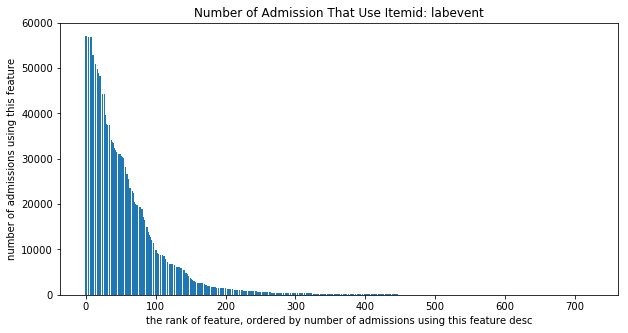

In [12]:
# finish stats in seperate py file for the convenience of multi-processing
labevent_histo = np.load('res/labevent_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(labevent_histo))],[int(r[1]) for r in labevent_histo])
plt.title('Number of Admission That Use Itemid: labevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

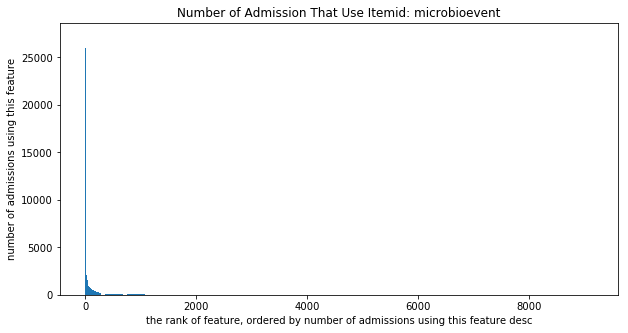

In [13]:
microbio_histo = np.load('res/microbio_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(microbio_histo))],[int(r[1]) for r in microbio_histo])
plt.title('Number of Admission That Use Itemid: microbioevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

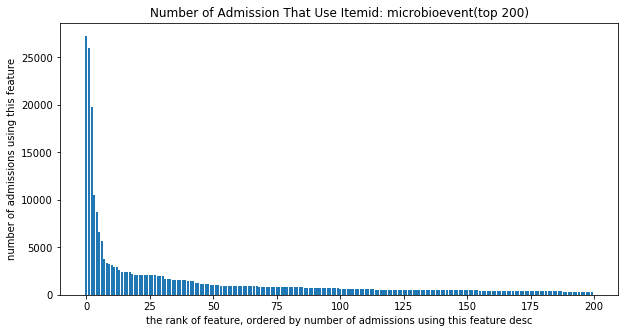

In [14]:
microbio_histo[:200]
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(microbio_histo[:200]))],[int(r[1]) for r in microbio_histo[:200]])
plt.title('Number of Admission That Use Itemid: microbioevent(top 200)')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

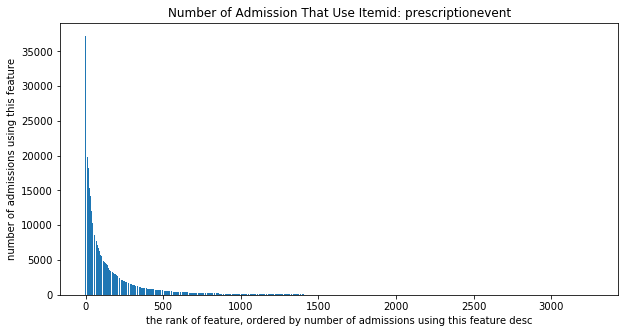

In [15]:
prescript_histo = np.load('res/prescript_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(prescript_histo))],[int(r[1]) for r in prescript_histo])
plt.title('Number of Admission That Use Itemid: prescriptionevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

In [16]:
print(itemids['input'])

[225936, 30044, 46770, 42596, 44526, 43038, 40327, 225883, 43829, 43750, 225931, 43007, 40743, 30001, 43744, 41390, 30138, 45865, 46057, 44064, 46387, 222051, 45915, 44407, 43081, 45333, 42576, 46583, 45929, 46630, 45640, 42456, 44539, 45090, 43764, 46496, 46362, 45741, 44673, 45803, 46564, 45505, 225991, 42344, 30320, 41358, 45166, 41776, 45270, 43023, 44605, 41357, 30332, 44061, 43474, 40645, 44690, 30119, 44945, 42575, 46101, 41712, 45771, 221456, 46002, 225876, 44505, 46264, 30166, 42999, 45073, 45787, 46026, 44610, 45838, 45125, 44292, 42083, 225860, 46218, 42554, 227535, 41194, 43087, 46040, 45802, 30148, 42438, 42629, 44112, 45214, 40880, 45683, 44054, 44527, 45688, 44818, 45912, 45675, 45182, 45863, 45114, 45458, 42429, 30375, 46330, 41216, 45588, 45871, 30399, 45275, 41356, 41913, 45230, 44144, 45587, 46093, 46419, 225973, 40030, 42674, 45956, 221319, 44795, 43845, 45317, 44182, 41449, 42065, 43835, 45627, 43957, 42230, 45187, 46643, 44696, 46610, 42208, 45765, 41094, 40850, 4

In [17]:
# inputevent histogram
sql = 'select sum(count) from (\
select count(distinct hadm_id) as count from mimiciii.inputevents_mv where itemid {0} and hadm_id in (select * from admission_ids) \
union all select count(distinct hadm_id) as count from mimiciii.inputevents_cv where itemid {0} and hadm_id in (select * from admission_ids) \
) t'
getNumberOfAdmissionThatUseStatId(sql, itemids['input'], admission_ids_txt,
                                  'res/inputevent_numberOfAdmissionThatUseItemid.npy')

print('input finished')

# outputevent histogram
sql = 'select count(distinct hadm_id) from mimiciii.outputevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['output'], admission_ids_txt,
                                  'res/outputevent_numberOfAdmissionThatUseItemid.npy')

print('output finished')

# chartevent
sql = 'select count(distinct hadm_id) from mimiciii.chartevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['chart'], admission_ids_txt,
                                  'res/chartevent_numberOfAdmissionThatUseItemid.npy')

print('chart finished')

100 0:00:01.513918 0:14:51.323764
200 0:00:01.519277 0:07:26.462496
300 0:00:01.524032 0:04:58.074080
400 0:00:01.530094 0:03:44.053200
500 0:00:01.535492 0:02:59.521320
600 0:00:01.538039 0:02:29.617688
700 0:00:01.542432 0:02:08.382028
800 0:00:01.544956 0:01:52.337856
900 0:00:01.547281 0:01:39.832644
1000 0:00:01.549520 0:01:29.804824
1100 0:00:01.551899 0:01:21.605160
1200 0:00:01.554408 0:01:14.819920
1300 0:00:01.557523 0:01:09.095848
1400 0:00:01.559659 0:01:04.139664
1500 0:00:01.562113 0:00:59.832516
1600 0:00:01.565492 0:00:56.113728
1700 0:00:01.568115 0:00:52.808472
1800 0:00:01.570767 0:00:49.857472
1900 0:00:01.572946 0:00:47.201852
2000 0:00:01.576276 0:00:44.897088
2100 0:00:01.579124 0:00:42.713876
2200 0:00:01.581673 0:00:40.765168
2300 0:00:01.584876 0:00:39.049764
2400 0:00:01.587713 0:00:37.396736
2500 0:00:01.590013 0:00:35.918736
2600 0:00:01.592915 0:00:34.502112
2700 0:00:01.595293 0:00:33.202840
2800 0:00:01.597263 0:00:32.020320
2900 0:00:01.599659 0:00:30.8

100 0:00:00.250017 0:02:27.190000
200 0:00:00.255061 0:01:14.939400
300 0:00:00.259514 0:00:50.754740
400 0:00:00.262781 0:00:38.425856
500 0:00:00.266007 0:00:31.109232
600 0:00:00.269184 0:00:26.152448
700 0:00:00.272558 0:00:22.669364
800 0:00:00.276124 0:00:20.070720
900 0:00:00.281787 0:00:18.177788
1000 0:00:00.284659 0:00:16.465184
1100 0:00:00.287528 0:00:15.105636
[(40055, 22818), (226559, 18632), (40054, 10499), (226560, 7817), (40069, 7374), (40059, 5250), (226627, 5011), (40076, 4633), (40060, 4471), (226633, 4303), (40065, 4022), (43175, 3589), (226588, 3373), (40052, 3365), (40064, 3213), (40061, 3202), (226576, 2937), (226626, 2920), (227510, 2624), (40067, 2185), (226579, 2112), (226575, 1974), (40071, 1853), (226571, 1626), (226599, 1466), (40286, 1118), (226580, 997), (40049, 983), (40048, 958), (227511, 954), (40094, 899), (226573, 687), (40053, 671), (40051, 647), (226561, 610), (40367, 599), (226583, 593), (40288, 586), (40072, 566), (43176, 561), (40085, 560), (22

100 0:00:00.289304 0:02:50.328268
200 0:00:00.300452 0:01:28.281552
300 0:00:00.305270 0:00:59.673492
400 0:00:00.309056 0:00:45.220672
500 0:00:00.312705 0:00:36.547500
600 0:00:00.318216 0:00:30.939280
700 0:00:00.323053 0:00:26.865236
800 0:00:00.326376 0:00:23.677632
900 0:00:00.329743 0:00:21.255816
1000 0:00:00.333162 0:00:19.306008
1100 0:00:00.336998 0:00:17.710056
1200 0:00:00.341147 0:00:16.408384
1300 0:00:00.343894 0:00:15.226464
1400 0:00:00.348410 0:00:14.278848
1500 0:00:00.351881 0:00:13.449384
1600 0:00:00.354808 0:00:12.680096
1700 0:00:00.357769 0:00:12.027960
1800 0:00:00.360574 0:00:11.435200
1900 0:00:00.363434 0:00:10.901516
2000 0:00:00.366217 0:00:10.426608
2100 0:00:00.369667 0:00:10.010176
2200 0:00:00.371871 0:00:09.595144
2300 0:00:00.374339 0:00:09.181512
2400 0:00:00.376482 0:00:08.825856
2500 0:00:00.378618 0:00:08.527876
2600 0:00:00.380763 0:00:08.230896
2700 0:00:00.383768 0:00:07.991192
2800 0:00:00.386043 0:00:07.696112
2900 0:00:00.388504 0:00:07.4

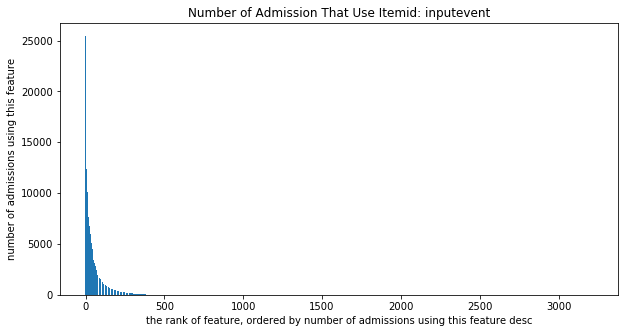

In [18]:
histo = np.load('res/inputevent_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: inputevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

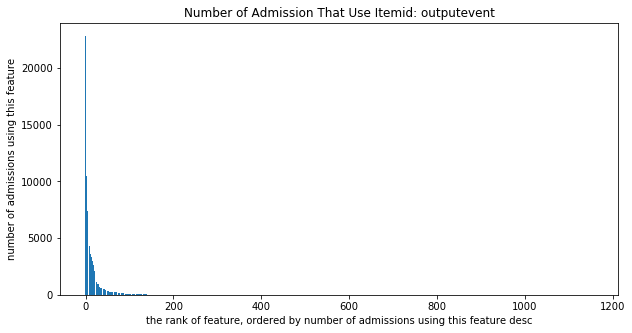

In [19]:
histo = np.load('res/outputevent_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: outputevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

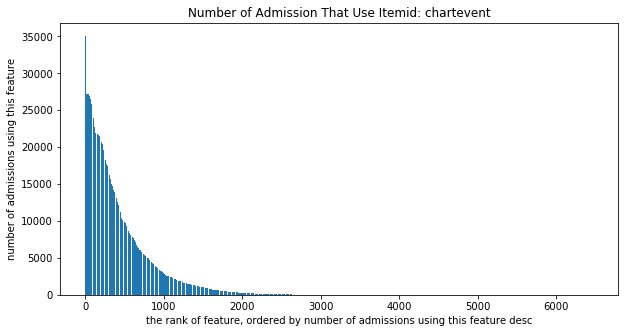

In [20]:
histo = np.load('res/chartevent_numberOfAdmissionThatUseItemid.npy').tolist()
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: chartevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')